# Demo
Integrating sub-cellular spots into single-cellular spots based on an improved version of TopACT (i.e., pytacs here).

In [1]:
import pytacs
import scanpy as sc
import seaborn as sns

In [2]:
# Step 1. Prepare the snRNA-seq and spRNA-seq data
data_preper = pytacs.AnnDataPreparer(
    sn_adata=sc.read_h5ad('snRNA_mouse_demo.h5ad'),
    sp_adata=sc.read_h5ad('spRNA_mouse_demo.h5ad'),
)
print(data_preper)

--- AnnDataPreparer (pytacs) ---
- sn_adata: AnnData object with n_obs × n_vars = 2000 × 769
    obs: 'cell_type', 'old_index'
- sp_adata: AnnData object with n_obs × n_vars = 6556 × 5227
    obs: 'x', 'y', 'old_index'
- sn_adata_withNegativeControl: _UNDEFINED
- normalized: False
--- --- --- --- ---



In [3]:
data_preper.simulate_negative_control(ratio_samplingFrom=0.1, negative_samples_proportion=0.1, ratio_mask=0.7)

/home/xndliu/miniconda3/envs/bioPy310/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 2223 × 769
    obs: 'cell_type'

In [4]:
data_preper.normalize()
data_preper

/home/xndliu/miniconda3/envs/bioPy310/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


--- AnnDataPreparer (pytacs) ---
- sn_adata: AnnData object with n_obs × n_vars = 2000 × 769
    obs: 'cell_type', 'old_index'
- sp_adata: AnnData object with n_obs × n_vars = 6556 × 5227
    obs: 'x', 'y', 'old_index'
- sn_adata_withNegativeControl: AnnData object with n_obs × n_vars = 2223 × 769
    obs: 'cell_type'
- normalized: True
--- --- --- --- ---

In [5]:
# Step 2. Train a local classifer
clf = pytacs.LocalClassifier(threshold_confidence=0.5)
clf.fit(
    sn_adata=data_preper.sn_adata_withNegativeControl
)

LocalClassifier(threshold_confidence=0.5)

In [6]:
# Step 3. Integrate spatial spots into single-cell spots
sph = pytacs.SpatialHandler(adata_spatial=data_preper.sp_adata,
                            local_classifier=clf,
                            max_spots_per_cell=8,
                            threshold_adjacent=1.5,
                            )
print(sph)

--- Spatial Handler (pytacs) ---
- adata_spatial: AnnData object with n_obs × n_vars = 6556 × 5227
    obs: 'x', 'y', 'old_index'
- threshold_adjacent: 1.5
- local_classifier: LocalClassifier(threshold_confidence=0.5)
    + threshold_confidence: 0.5
    + has_negative_control: True
- max_spots_per_cell: 8
- scale_rbf: 1.0
- filtrations: 0 fitted
- single-cell segmentation:
    + new samples: 0
    + AnnData: _UNDEFINED
--- --- --- --- --- ---



In [7]:
sph.run_segmentation(
    coverage_to_stop=0.5,
    max_iter=3000,
    verbose=False,
    warnings=False,
    print_summary=True,
)

--- Summary ---
Queried 3000 spots (with replacement), of which 0 made up confident single cells.
Classes total: {}
Coverage: 14.02%
--- --- --- --- ---



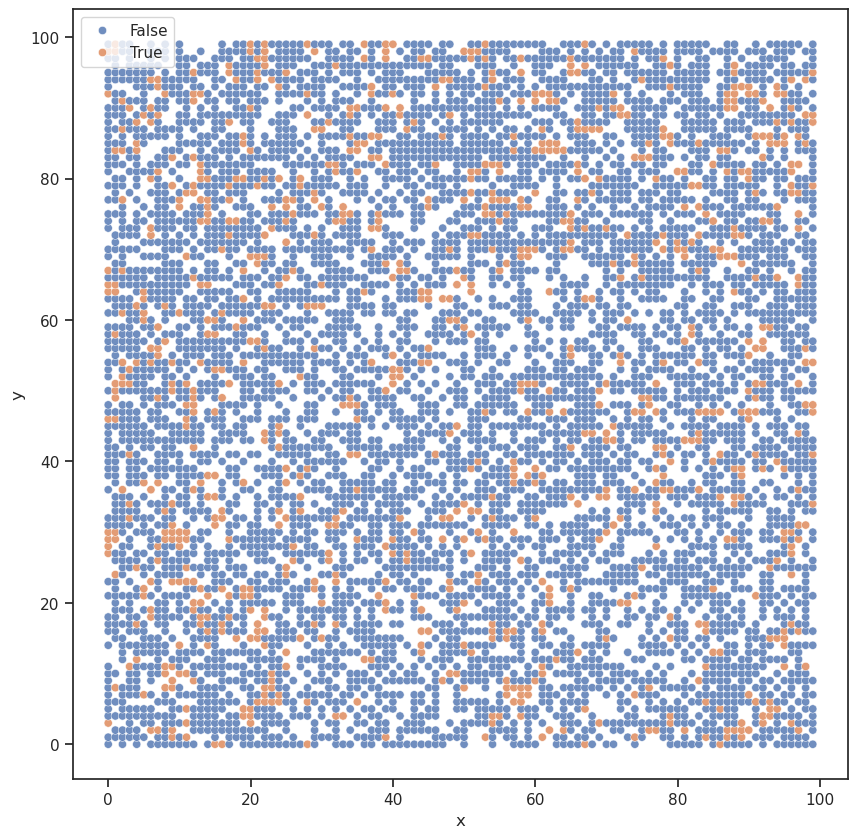

In [8]:
# See the integrated spots
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
sns.set_theme(style='ticks')
sns.scatterplot(
    x=data_preper.sp_adata.obs['x'],
    y=data_preper.sp_adata.obs['y'],
    hue=sph.mask_newIds>-1,
    alpha=0.8,
)
plt.show()

In [9]:
# Get integrated single-cell level ST data
sp_singleCell = sph.run_getSingleCellAnnData()

/mnt/d/xtdisk_ubuntu/xndliu/noisePatternProject/topact_rewrite/pytacs/spatial.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sc_adata.obs['confidence'][ix_new] = self.confidences_new[ix_new]


In [10]:
print(sp_singleCell)

AnnData object with n_obs × n_vars = 615 × 5227
    obs: 'x', 'y', 'old_index', 'confidence'


In [11]:
sp_singleCell.obs['confidence']

2       0.937415
17      0.620465
18      0.647681
20      0.790574
32      0.549148
          ...   
6511    0.966844
6514    0.932615
6539    0.746439
6547    0.629520
6551    0.619786
Name: confidence, Length: 615, dtype: float64